In [8]:
from google.colab import files
files.upload()


Saving train.csv to train (5).csv


In [9]:
!pip install -q --upgrade seaborn

**Can you predict the Number of Likes a Youtube Video will get ?**

As YouTube becomes one of the most popular video-sharing platforms, YouTuber is developed as a new type of career in recent decades. YouTubers earn money through advertising revenue from YouTube videos, sponsorships from companies, merchandise sales, and donations from their fans. In order to maintain a stable income, the popularity of videos become the top priority for YouTubers. Meanwhile, some of our friends are YouTubers or channel owners in other video-sharing platforms. This raises our interest in predicting the performance of the video. If creators can have a preliminary prediction and understanding on their videos’ performance, they may adjust their video to gain the most attention from the public.

You have been provided details on videos along with some features as well. Can you accurately predict the number of likes for each video using the set of input variables?

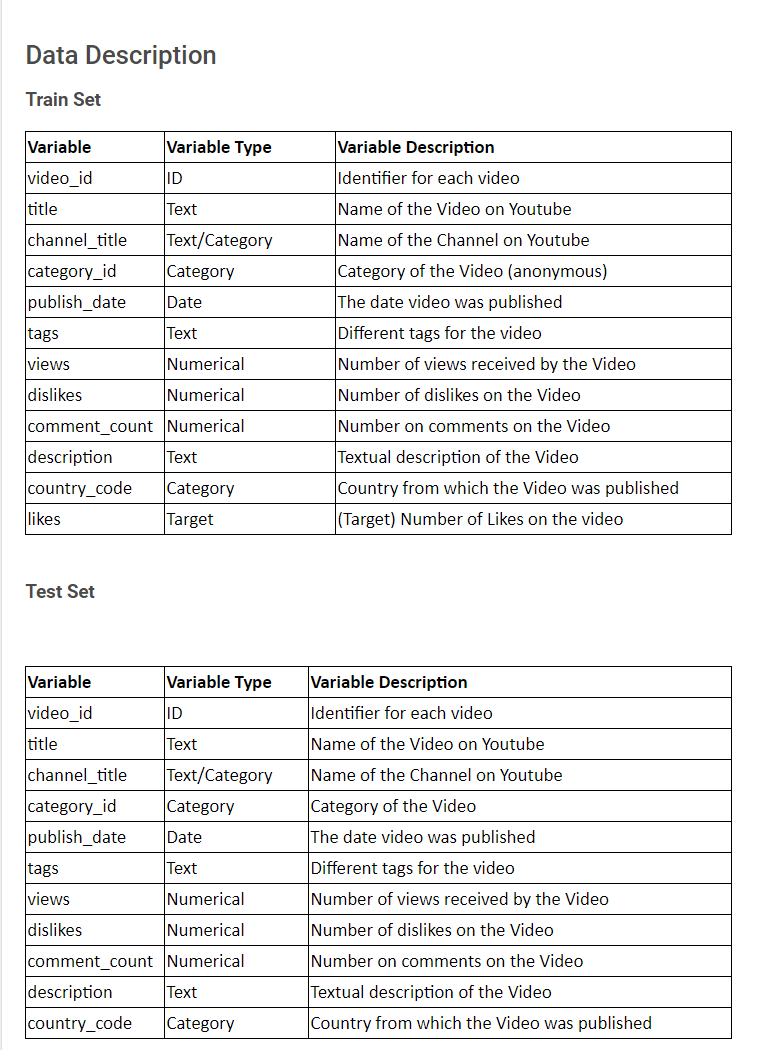

#### **Hypothesis Generation**
Simply put, a hypothesis is a possible view or assertion of an analyst about the problem he or she is working upon. It may be true or may not be true.

* **Do videos with more views get more likes** ?
* **Do videos with more comments get more likes ?**
* **Do with videos with more dislikes get less likes ?**
* **Do longer videos get more likes than shorter videos ?**
* **Do descriptive videos get more number of likes ?**
* **Does a channel affect the number of likes?**
* **Does the country of origin affect the number of likes ?**
* **Do people post more videos on weekends than weekdays ?**

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

# **EDA**

Now lets go on to read and have a look at each of the files.

In [109]:
youtube = pd.read_csv('train (5).csv')
train, test = train_test_split(youtube,random_state = 1 , test_size=0.2)

Lets go and explore our training and test datasets. We will do the following steps:

1. Brief Look at the Dataset
2. See the dataset shape.
3. Target Distribution.
4. See the variables datatypes.
5. See the number of missing/null values.
6. See the number of unique values in each variable. 


In [110]:
youtube.describe()

video_id   category_id  ...  comment_count         likes
count  26061.000000  26061.000000  ...   26061.000000  2.606100e+04
mean   44560.500518     21.498292  ...    1693.145620  1.258067e+04
std    25688.103401      6.304901  ...    9247.594359  5.856355e+04
min        2.000000      1.000000  ...       0.000000  0.000000e+00
25%    22523.000000     22.000000  ...      93.000000  6.830000e+02
50%    44648.000000     24.000000  ...     389.000000  2.541000e+03
75%    66744.000000     25.000000  ...    1211.000000  8.553000e+03
max    89272.000000     43.000000  ...  692312.000000  3.880088e+06

[8 rows x 6 columns]

### **1. Brief look at the dataset**.

In [111]:
train.head(3)
test.head(3)

video_id  ...   likes
792       41063  ...  4189.0
11404     26867  ...    94.0
23783     86186  ...     7.0

[3 rows x 12 columns]

video_id  ...    likes
13024     27925  ...    952.0
9352      63659  ...    153.0
25300     69066  ...  10605.0

[3 rows x 12 columns]

In [112]:
ID_COL, TARGET_COL = 'video_id', 'likes'

### **2. Dataset Shape (Number of Samples and Variables in the dataset)**

In [113]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 20848 samples and 12 variables

Test contains 5213 samples and 12 variables

The dataset contains 10 features


### **3.Target Distribution**

This is a regression problem. Let's look the at the 'likes' distribution.

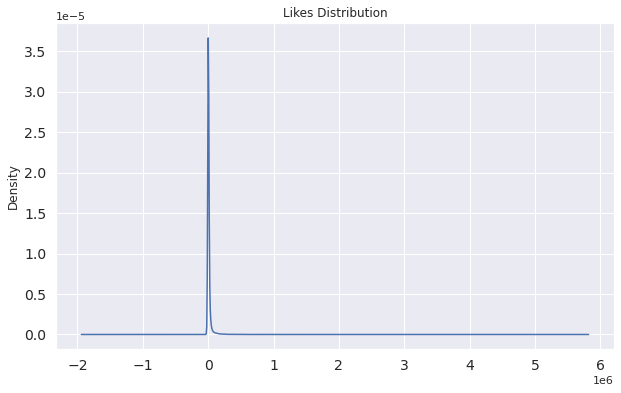

In [114]:
_ = train[TARGET_COL].plot(kind = 'density', title = 'Likes Distribution', fontsize=14, figsize=(10, 6))

**Question**

***Highly Right Skewed Data.***
<br>
What can we do to change this distribution and make it more normal ?

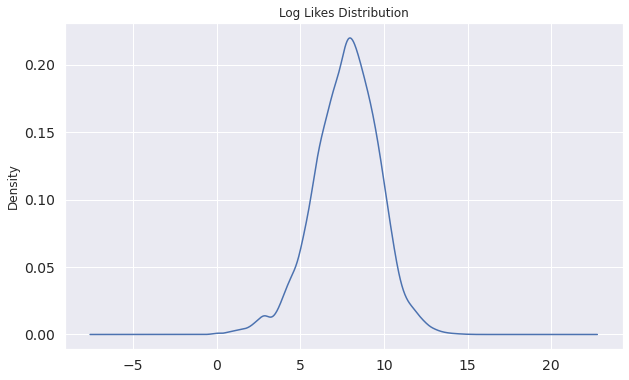

In [115]:
_ = pd.Series(np.log1p(train[TARGET_COL])).plot(kind = 'density', title = 'Log Likes Distribution', fontsize=14, figsize=(10, 6))

Let's the see the same for boxplot.

1. Without log-transformation.
2. With log-transformation.

**Original Target**

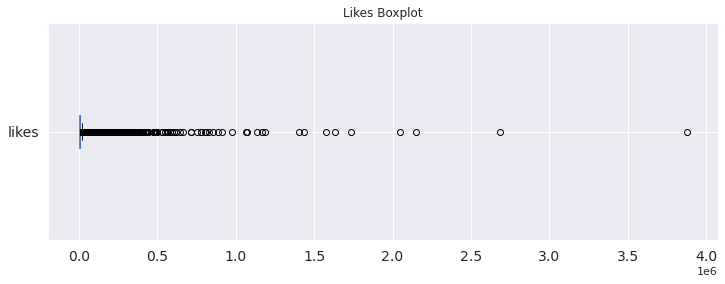

In [117]:
_ = train[TARGET_COL].plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Likes Boxplot', fontsize=14)

**Log Transformed Target**

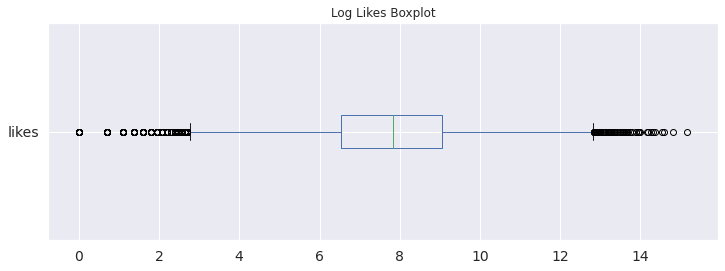

In [118]:
_ = pd.Series(np.log1p(train[TARGET_COL])).plot(kind = 'box',
                                                vert=False,
                                                figsize=(12, 4),
                                                title = 'Log Likes Boxplot',
                                                fontsize=14)

###**4. Variable Datatypes**

Lets have a look at the kind of data types that is being used to store the variables in pandas.

pandas info() method on dataframe allows to do that. For each variable we can see the number of non-null values along with their datatypes.



In [119]:
train.head(1)

video_id                          title  ... country_code   likes
792     41063  Most Used Emoji Guessing Game  ...           CA  4189.0

[1 rows x 12 columns]

In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20848 entries, 792 to 235
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       20848 non-null  int64  
 1   title          20848 non-null  object 
 2   channel_title  20848 non-null  object 
 3   category_id    20848 non-null  float64
 4   publish_date   20848 non-null  object 
 5   tags           20848 non-null  object 
 6   views          20848 non-null  float64
 7   dislikes       20848 non-null  float64
 8   comment_count  20848 non-null  float64
 9   description    20848 non-null  object 
 10  country_code   20848 non-null  object 
 11  likes          20848 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.1+ MB


Looks like we have a mixture of datatypes, a lot of these variables are object datatypes. Object datatypes are used to store strings along with other non-numeric data. This is obvious since we encountered a lot of strings when we had a look at the dataset.

Machine Learning Models understand only numbers so we will have to later convert these strings to numbers

### **5. Null Values**

Although the info() function did tell us about non-null values ideally we want to have a look at the percentage of null values in each variable.

In [121]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

likes            0.0
country_code     0.0
description      0.0
comment_count    0.0
dislikes         0.0
views            0.0
tags             0.0
publish_date     0.0
category_id      0.0
channel_title    0.0
title            0.0
video_id         0.0
dtype: float64

### **6. Unique values in each variable**

In [122]:
train.nunique()

video_id         20848
title            20814
channel_title     5088
category_id         17
publish_date       327
tags             17307
views            20414
dislikes          2372
comment_count     4480
description      18847
country_code         4
likes            10541
dtype: int64

The numerical features 'views', 'dislikes', 'comment_count' contain a lot of unique values which is quite obvious.


## **Analyzing Each Variable & their relationships**

There are 4 types of features that we have:

1. Numerical
2. Categorical
3. Textual
4. DateTime


Also our target is Continuous

For each feature type we will be perform two types of analysis:

1. Univariate: Analyze 1 feature at a time

2. Bivariate: Analyze the relationship of that feature with target variable, i.e. 'likes'




In [123]:
train.columns

Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code', 'likes'],
      dtype='object')

### **Numerical Variables**

In [124]:
num_cols = ['views', 'dislikes', 'comment_count']

#### **Univariate Analyis**

##### **Boxplots**

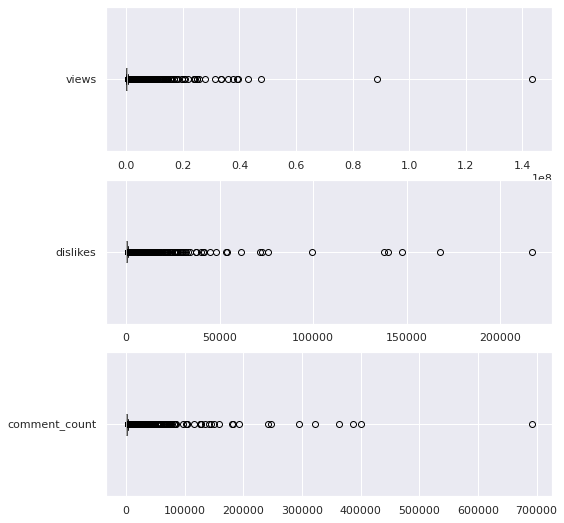

In [125]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

##### **Density Plots**

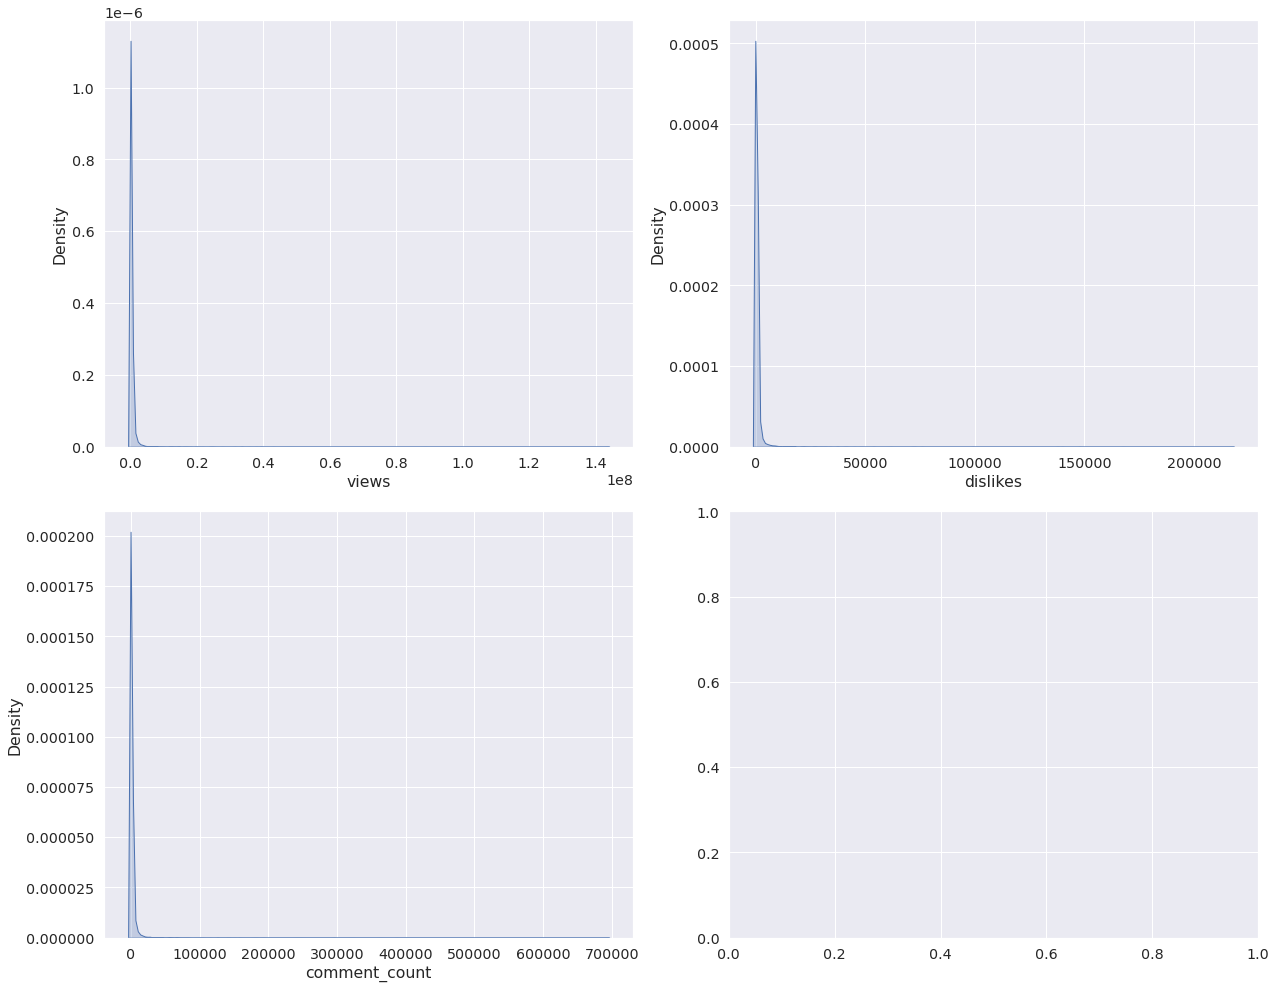

In [126]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

**Log Transformation of Numerical Columns**

In [127]:
for c in num_cols + ['likes']:
  train[c] = np.log1p(train[c]) 

**Boxplots**

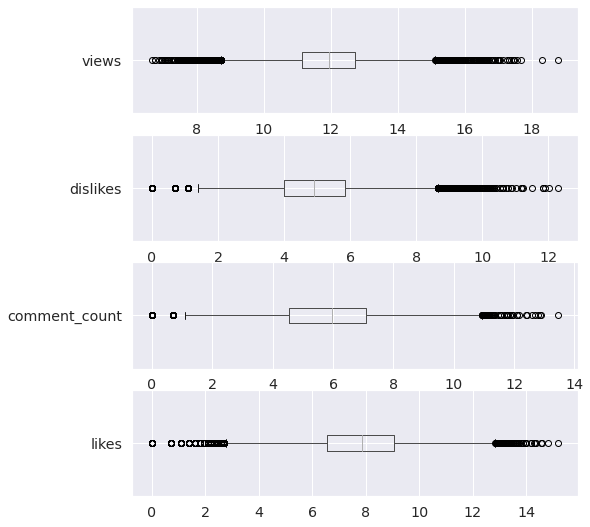

In [128]:
fig, axes = plt.subplots(4, 1, figsize=(8, 9))
for i, c in enumerate(num_cols + ['likes']):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

**Density Plots**

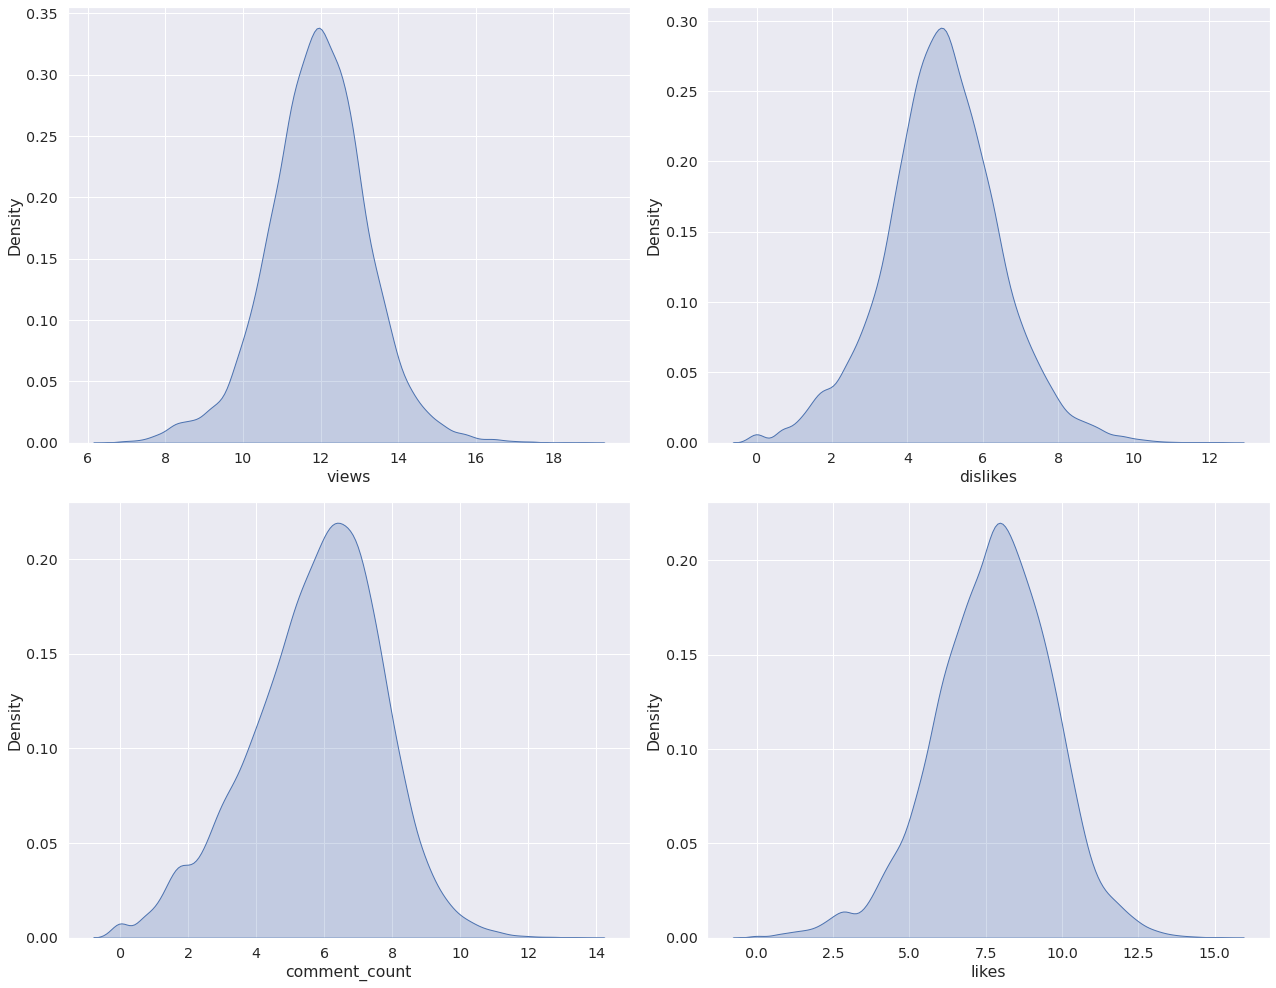

In [129]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols + ['likes']):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

#### **Bivariate Analysis**

##### **Correlation HeatMaps**

<Figure size 1008x576 with 0 Axes>

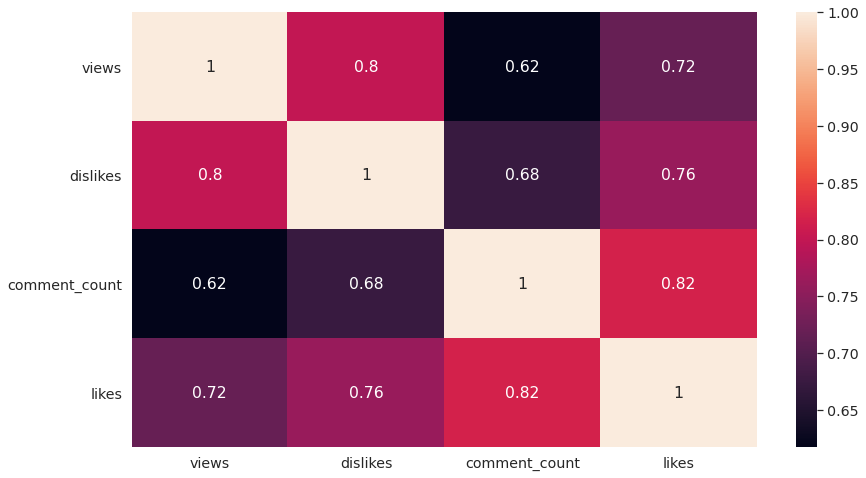

In [130]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[num_cols + ['likes']].corr(), annot=True)

##### **Pair Plots**

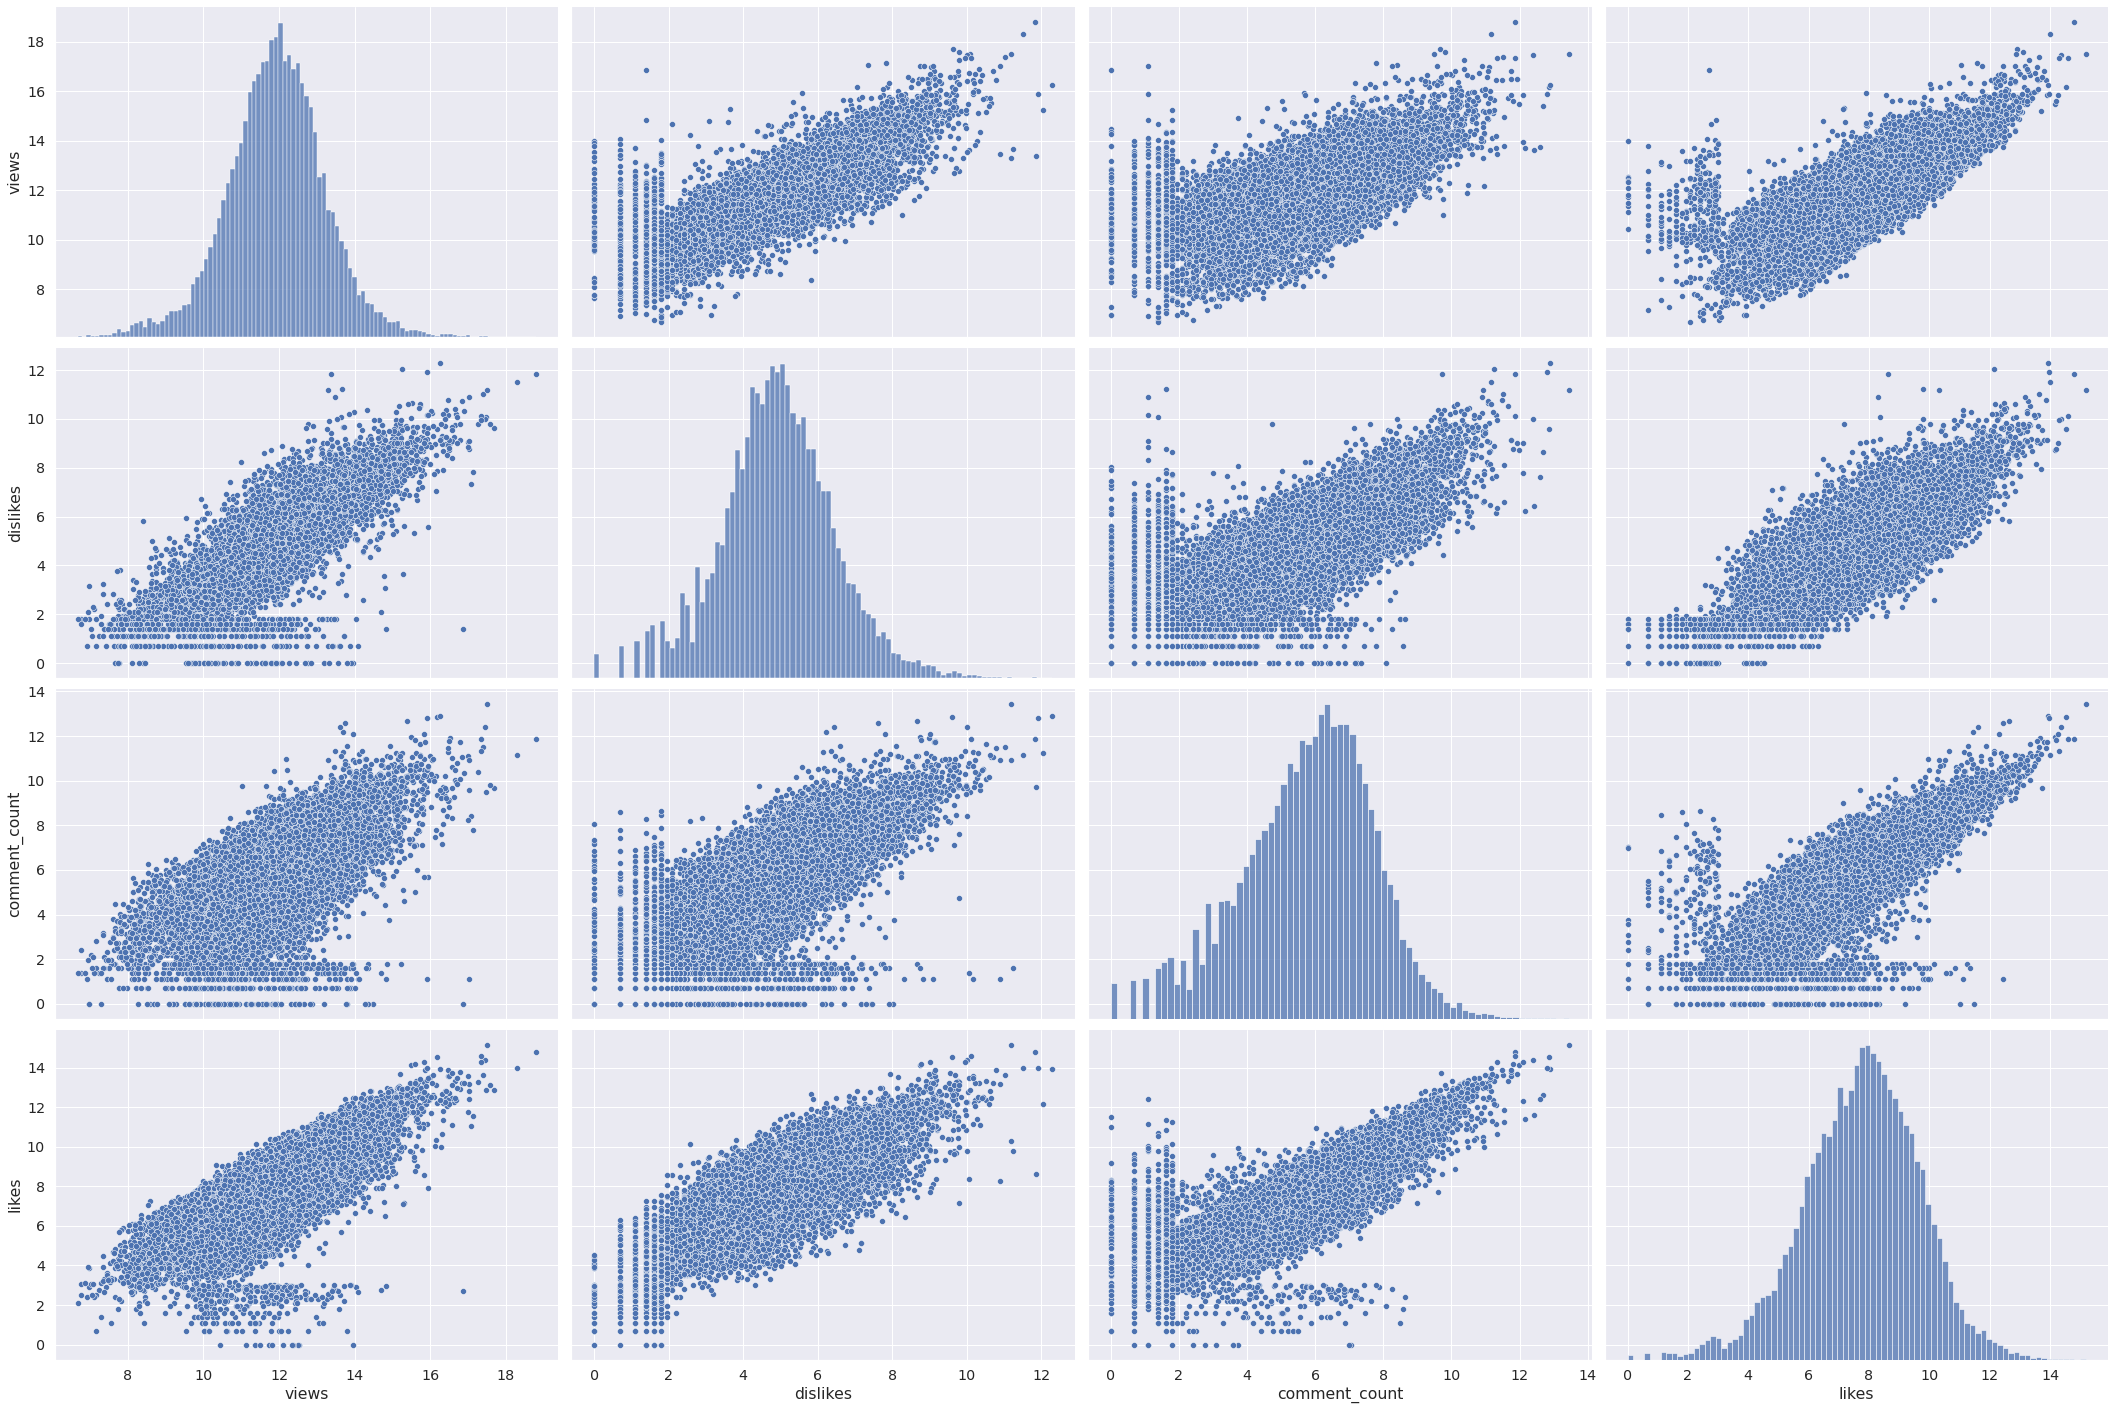

In [131]:
_ = sns.pairplot(train[num_cols + ['likes']], height=5, aspect=24/16)

**Answering Hypothesis**

* **Do videos with more views get more likes** ?

Yes they do, we have a high correlation of 0.72 also the plot between the two variables shows this.

* **Do videos with more comments get more likes** ?

Yes they do, we have a high correlation of 0.82 also the plot between the two variables shows this.

* **Do videos with more dislikes get less likes** ?

Any form of popularity is good popularity. As the number dislikes increases, number of views increases too, and so the number of likes.

* **Do longer videos get more likes than shorter videos ?**

We don't have data to answer this question. Should we try to collect more data ? What other features could be helpful ?


Categorical variables

##### **Pie Charts**

In [132]:
train.columns

Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code', 'likes'],
      dtype='object')

In [133]:
train['channel_title'].nunique()

5088

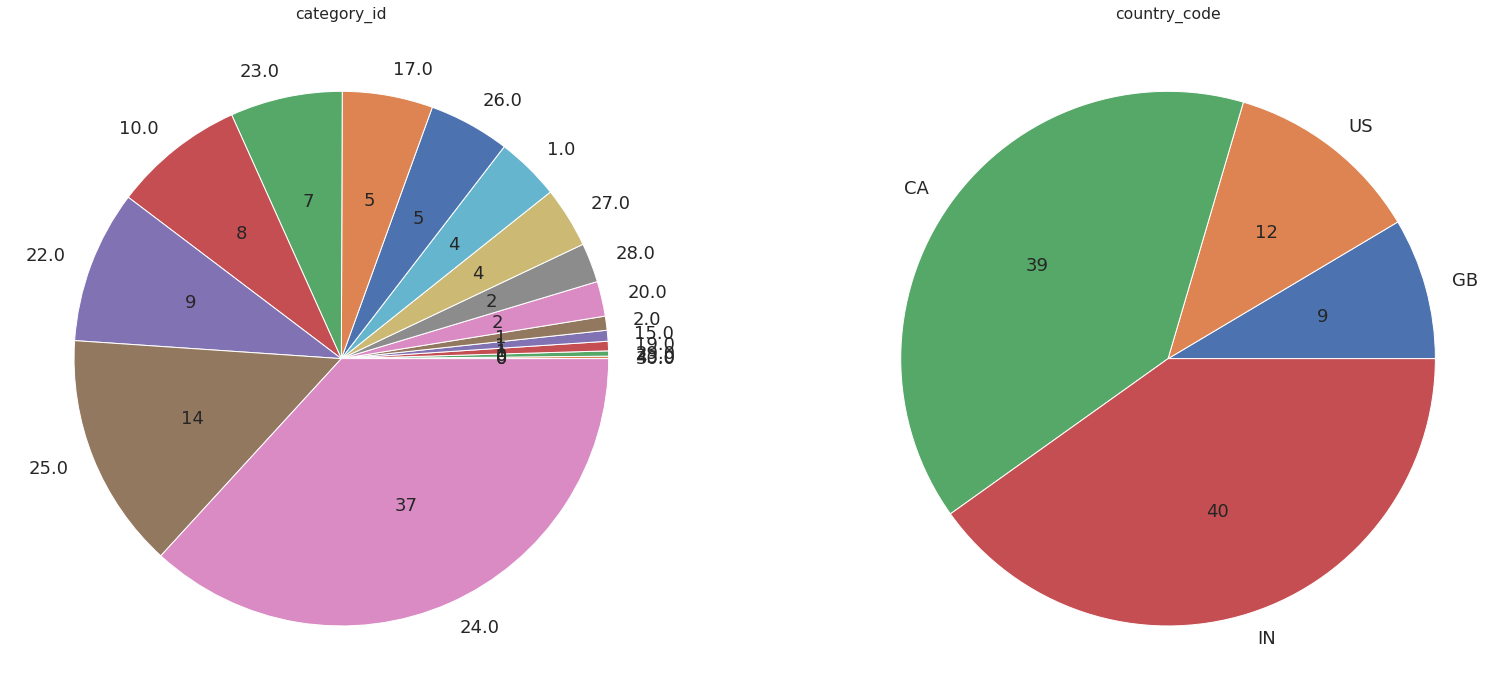

In [134]:
cat_cols = ['category_id', 'country_code', 'channel_title']
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for i, c in enumerate(['category_id', 'country_code']):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=18)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

**Horizontal Bar Plots**

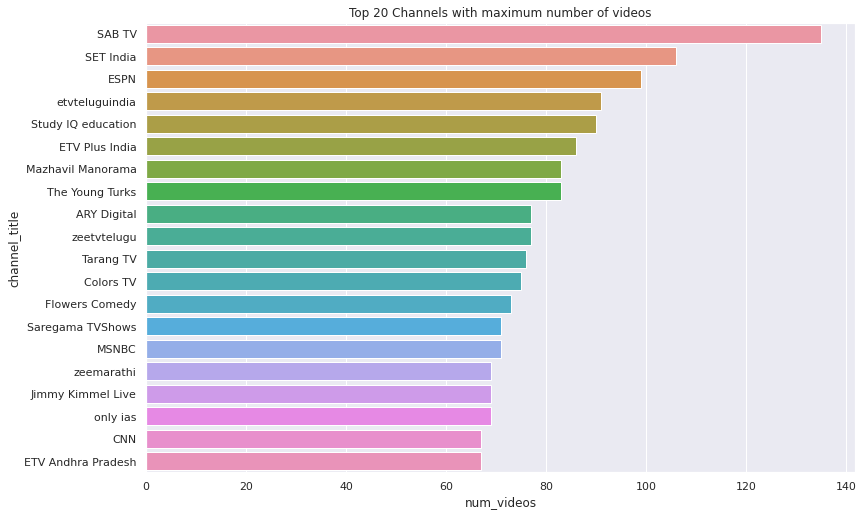

In [135]:
sns.set(rc={'figure.figsize':(12.7, 8.27)})

top_20_channels = train['channel_title'].value_counts()[:20].reset_index()
top_20_channels.columns = ['channel_title', 'num_videos']

_ = sns.barplot(data = top_20_channels, y = 'channel_title', x = 'num_videos')
_ = plt.title("Top 20 Channels with maximum number of videos")

#### **Bivariate Analyisis**

1.   List item
2.   List item



**Country Wise Number of Videos for Channel**

In [136]:
country_wise_channels = train.groupby(['country_code', 'channel_title']).size().reset_index()
country_wise_channels.columns = ['country_code', 'channel_title', 'num_videos']
country_wise_channels = country_wise_channels.sort_values(by = 'num_videos', ascending=False)

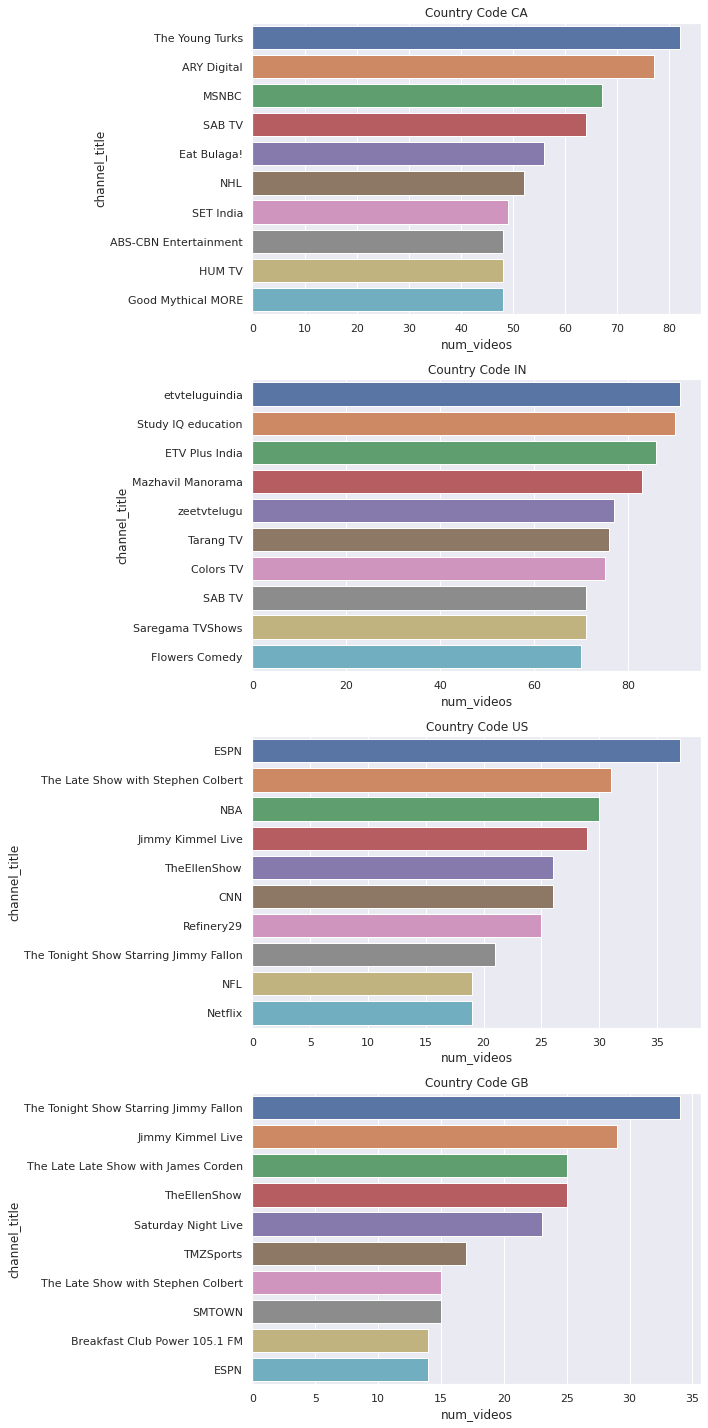

In [137]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'num_videos', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

#### **Multivariate Analysis**

Analyzing more than two variables at once

**Country Wise Likes for Channel**

What are the variables that we want to analyze here ?

In [138]:
country_wise_channels = train.groupby(['country_code', 'channel_title'])['likes'].max().reset_index()
country_wise_channels = country_wise_channels.sort_values(by = ['likes'], ascending=False)

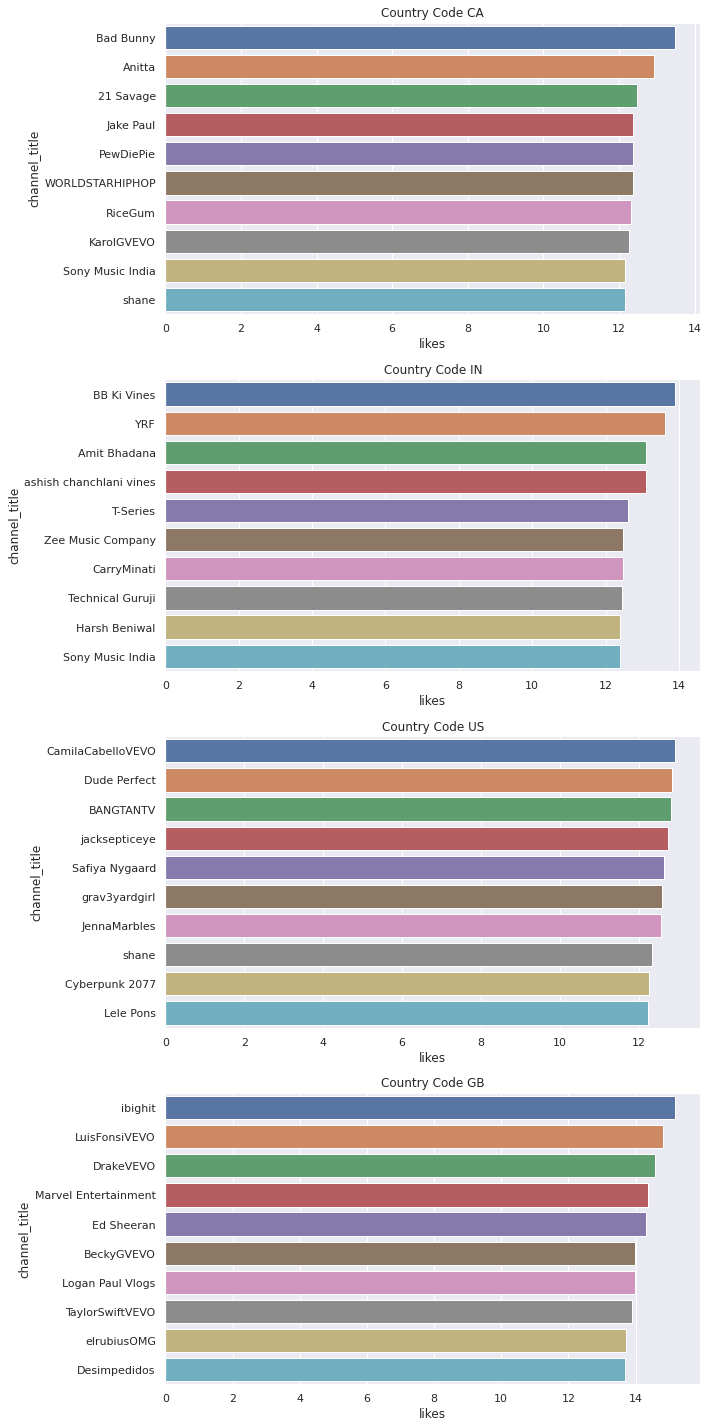

In [139]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'likes', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

**Question** 

* **Does a channel affect the number of likes?**

##### **CatPlots**

**Likes Distribution Per Category**

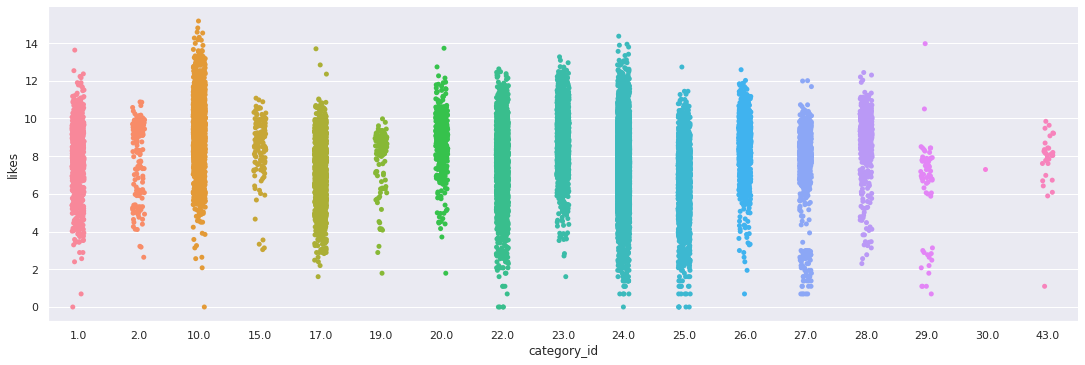

In [140]:
_ = sns.catplot(x="category_id", y="likes", data=train, height=5, aspect=24/8)

**Likes Distribution Per Country**

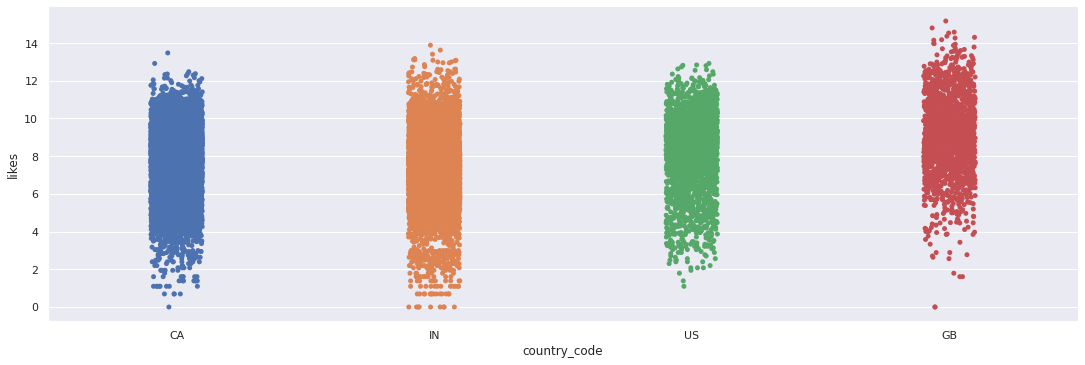

In [141]:
_ = sns.catplot(x="country_code", y="likes", data=train, height=5, aspect=24/8)

**Mean Likes Per Country**

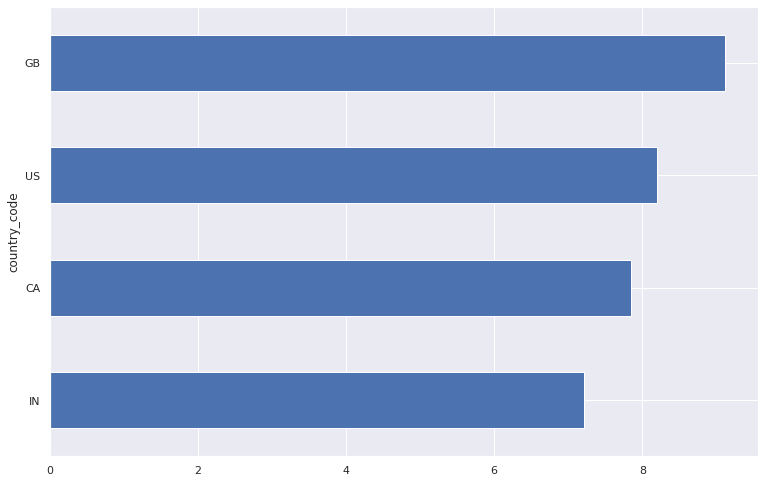

In [142]:
_ = train.groupby('country_code')['likes'].mean().sort_values().plot(kind = 'barh')

**Question** 

* **Does a country affect the number of likes?**

Looks like videos posted in England have an higher average number of likes compared to videos posted in India.

### **DateTime Variables**

In [143]:
train['publish_date'] = pd.to_datetime(train['publish_date'], format='%Y-%m-%d')
test['publish_date'] = pd.to_datetime(test['publish_date'], format='%Y-%m-%d')
train['publish_date']

792     2018-03-20
11404   2018-03-02
23783   2018-03-08
11483   2017-12-30
21553   2018-03-19
           ...    
10955   2018-06-04
17289   2018-01-31
5192    2018-05-02
12172   2018-03-10
235     2018-04-06
Name: publish_date, Length: 20848, dtype: datetime64[ns]

**Value Counts of Videos Year Wise**

**Mininum and Maximum Date**

In [144]:
train['publish_date'].min(), train['publish_date'].max()

(Timestamp('2007-03-05 00:00:00'), Timestamp('2018-06-14 00:00:00'))

In [145]:
train['publish_date'].dt.year.value_counts()

2018    15024
2017     5746
2015       16
2016       13
2011       11
2014        8
2013        8
2009        7
2012        5
2010        4
2008        3
2007        3
Name: publish_date, dtype: int64

**Number of Videos in Data datewise**

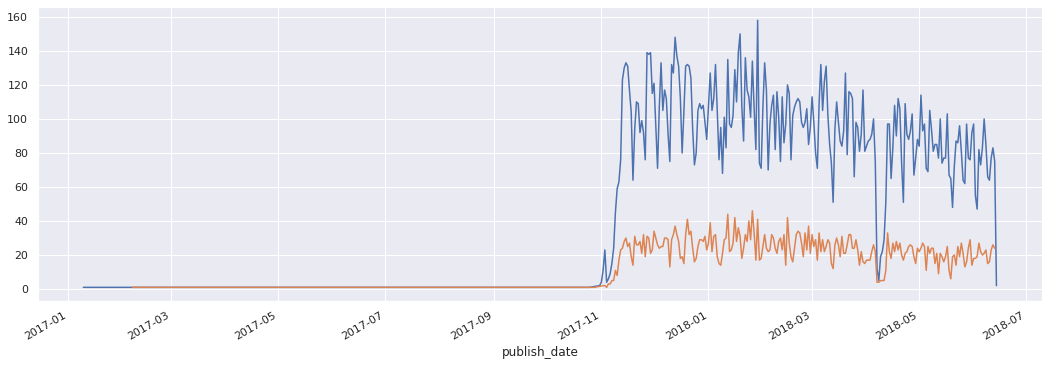

In [146]:
latest_data_train = train[train['publish_date'] > '2017']
latest_data_test = test[test['publish_date'] > '2017']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(18, 6))
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(18, 6))

In [147]:
test.shape, train.shape

((5213, 12), (20848, 12))

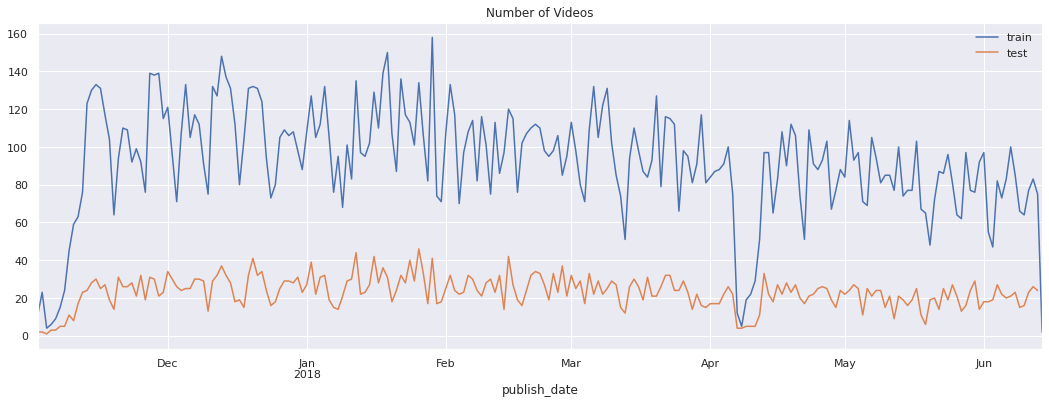

In [148]:
latest_data_train = train[train['publish_date'] > '2017-11']
latest_data_test = test[test['publish_date'] > '2017-11']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().rename('train').plot(figsize=(18, 6), title = 'Number of Videos')
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().rename('test').plot(figsize=(18, 6), title = 'Number of Videos')
_ = plt.legend()

**Mean Likes in Data Sorted by Date**

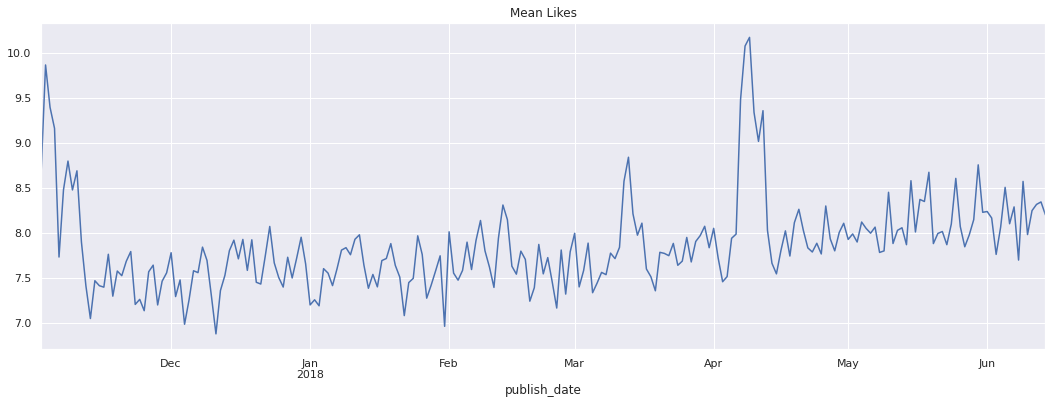

In [149]:
latest_data = train[train['publish_date'] > '2017-11']
_ = latest_data.sort_values(by = 'publish_date').groupby('publish_date')['likes'].mean().plot(figsize=(18, 6), title="Mean Likes")

**Number of Videos by Country**

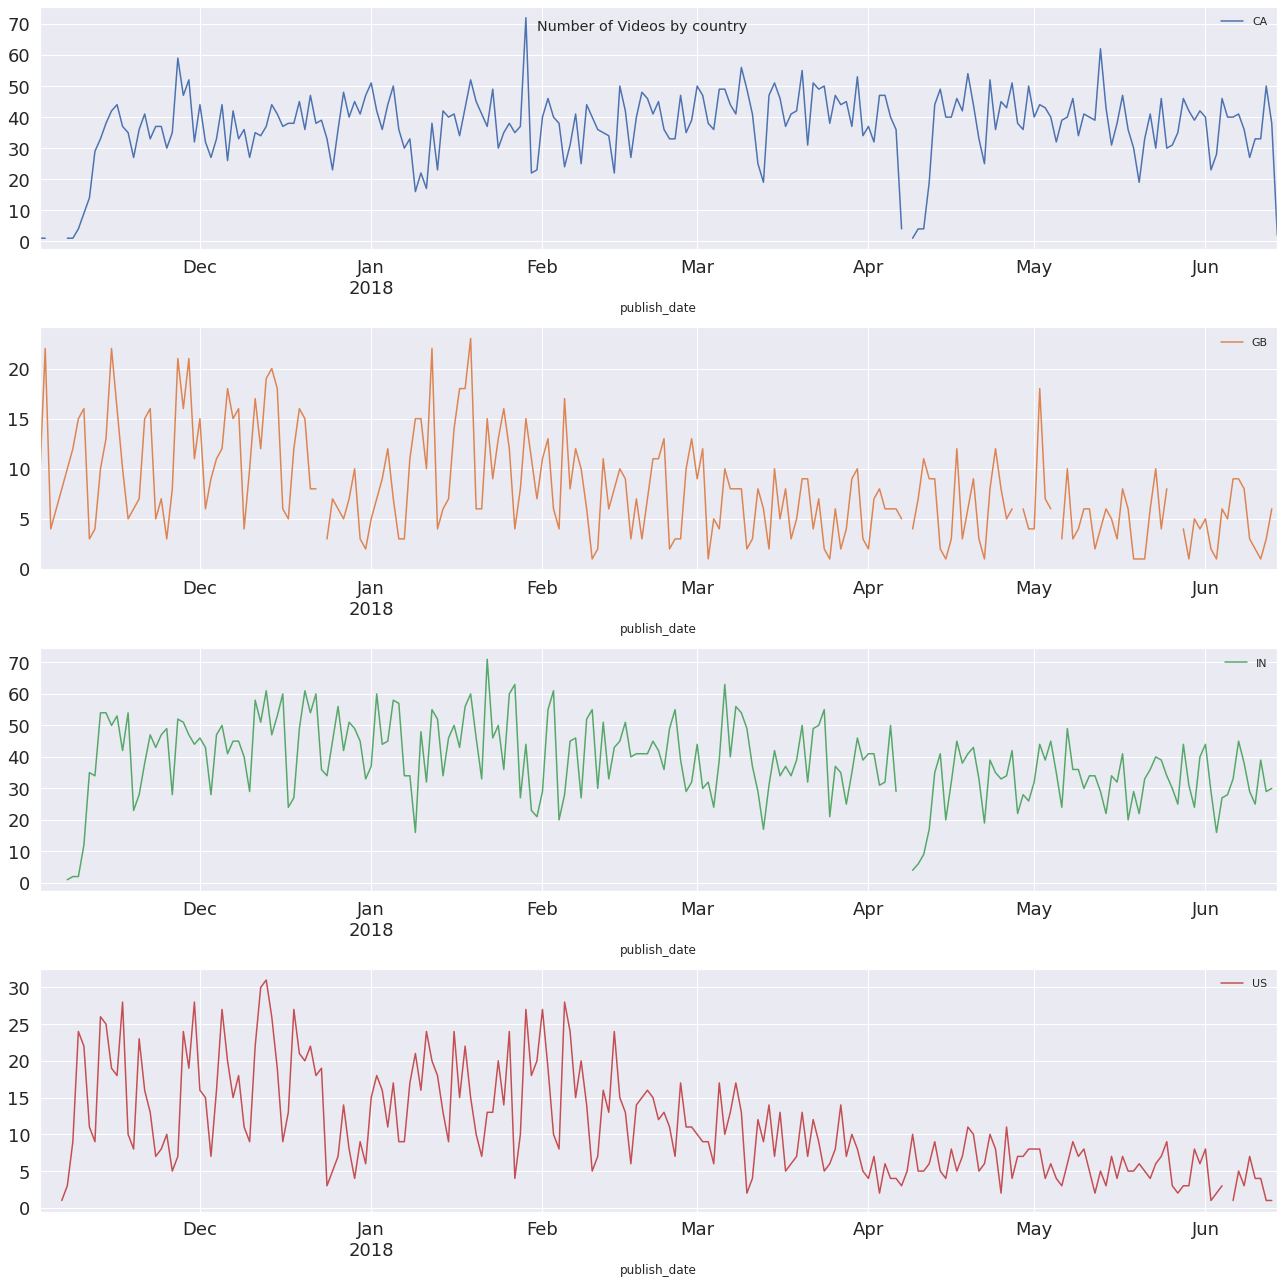

In [150]:
tmp = latest_data.groupby(['publish_date', 'country_code']).size().reset_index()
_ = tmp.pivot_table(index = 'publish_date', columns = 'country_code', values=0).plot(subplots=True, figsize=(18, 18),
                                                                                           title='Number of Videos by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

**Why could be the reason for drop in Number of Videos for GB and USA ?**

**Mean Number of Likes by Country sorted by Date**

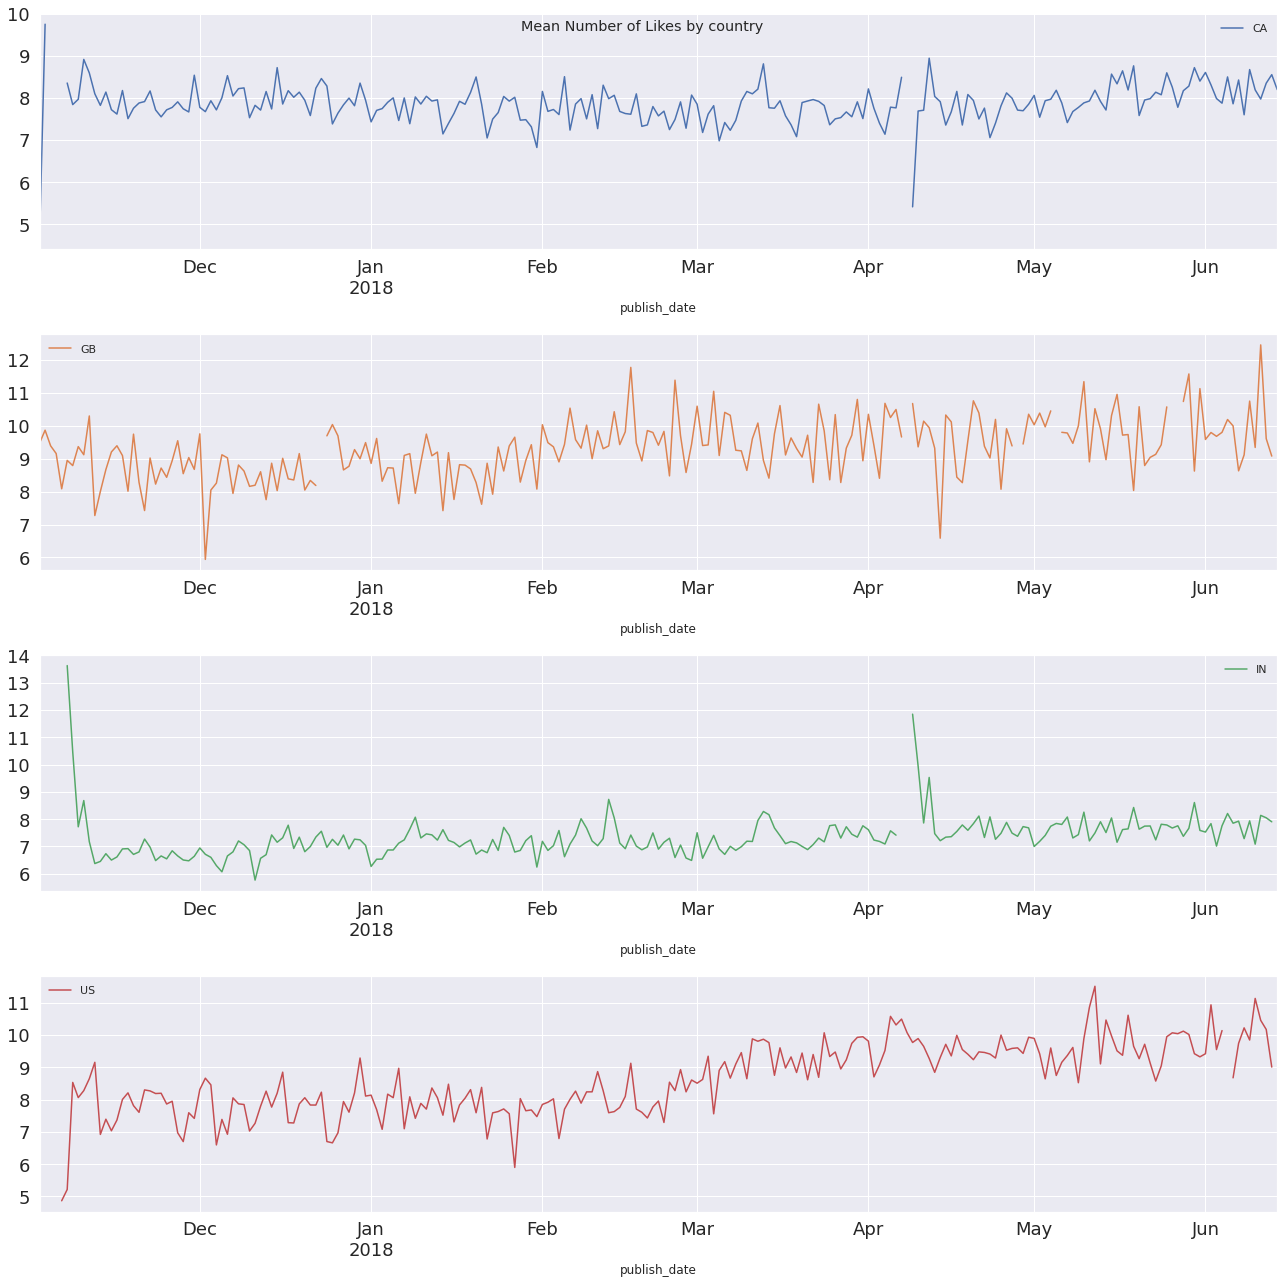

In [151]:
tmp = latest_data.groupby(['publish_date', 'country_code'])['likes'].mean().reset_index()
_ = tmp.pivot_table(index = 'publish_date', columns = 'country_code', values='likes').plot(subplots=True, figsize=(18, 18),
                                                                                           title='Mean Number of Likes by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

**Do people post more videos on weekends than weekdays ?**

In [152]:
train['dayofweek'] = train['publish_date'].dt.dayofweek

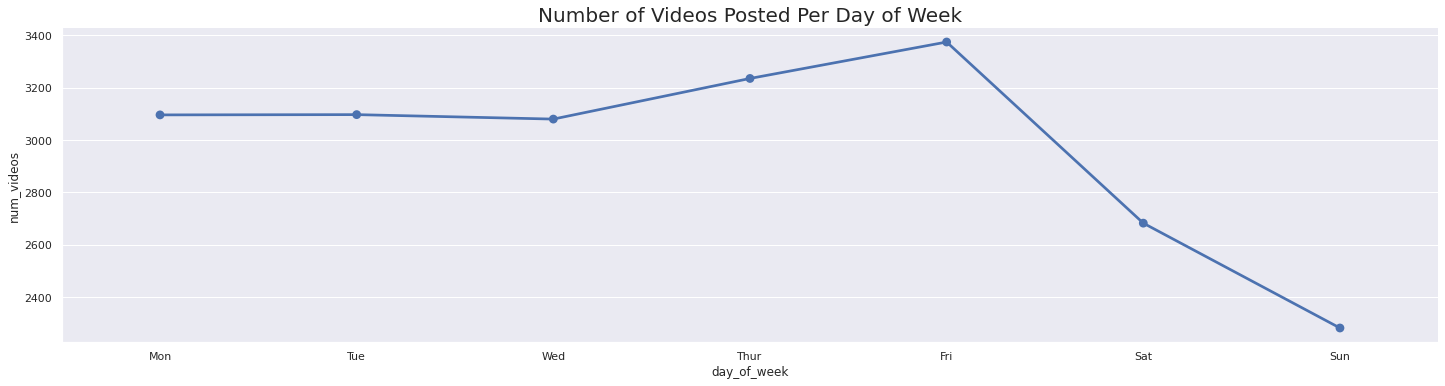

In [153]:
n_videos_per_day_of_week = train['dayofweek'].value_counts().sort_index().reset_index()
n_videos_per_day_of_week.columns = ['day_of_week', 'num_videos']
n_videos_per_day_of_week['day_of_week'] = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
_ = sns.catplot(x = 'day_of_week', y = 'num_videos', data = n_videos_per_day_of_week, kind = 'point',aspect = 24/6)
_ = plt.title("Number of Videos Posted Per Day of Week", fontsize=20)

It looks our hypothesis is incorrect in context of the current data. Most of the videos were published on Friday, but Saturday and Sunday saw the least number of videos published

### **Textual Data**

In [154]:
text_cols = ['title', 'tags', 'description']

#### **Word Clouds**

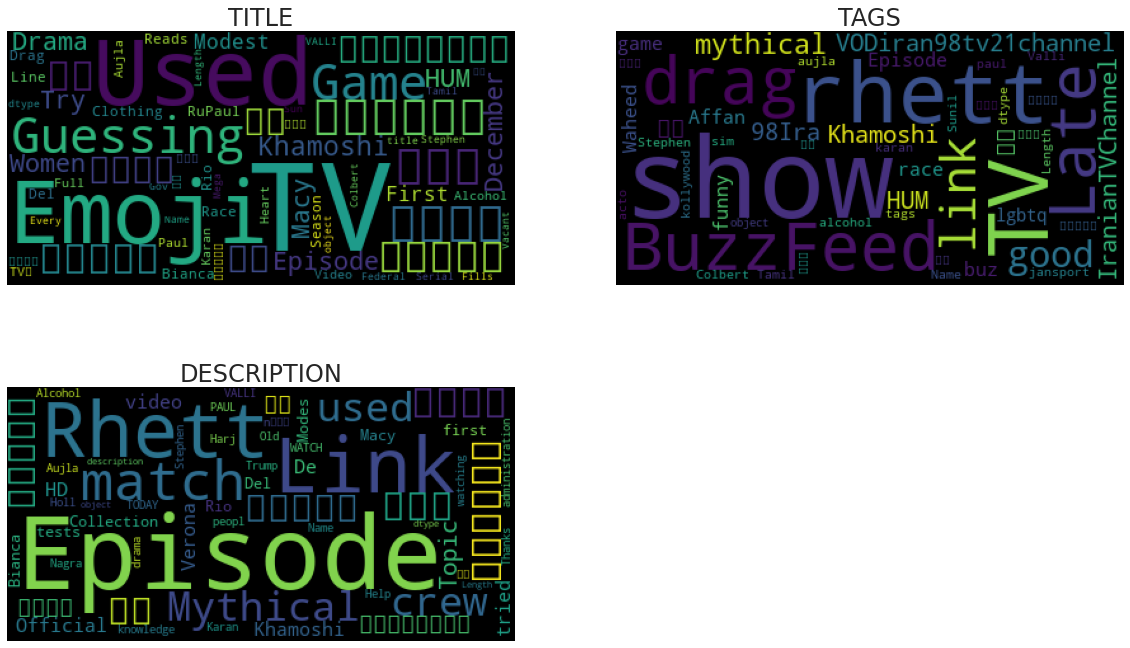

In [155]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['|']), random_state = 42)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(text_cols):
  op = wc.generate(str(train[c]))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(c.upper(), fontsize=24)
  _ = axes[i].axis('off')

_ = fig.delaxes(axes[3])

In [156]:
train['likes'].describe()

count    20848.000000
mean         7.742830
std          1.926838
min          0.000000
25%          6.529419
50%          7.841689
75%          9.048997
max         15.171369
Name: likes, dtype: float64

In [157]:
100 * ((train['likes'] > 10).sum()/train.shape[0])

10.725249424405218

In [158]:
def plot_countrywise(country_code = 'IN'):
  country = train[train['country_code'] == country_code]
  country = country[country['likes'] > 10]
  fig, axes = plt.subplots(2, 2, figsize=(20, 12))
  axes = [ax for axes_row in axes for ax in axes_row]

  for i, c in enumerate(text_cols):
    op = wc.generate(str(country[c]))
    _ = axes[i].imshow(op)
    _ = axes[i].set_title(c.upper(), fontsize=24)
    _ = axes[i].axis('off')

  fig.delaxes(axes[3])
  _ = plt.suptitle(f"Country Code: '{country_code}'", fontsize=30)

**US HIGHLY LIKED YOUTUBE VIDEOS TOP WORDS**

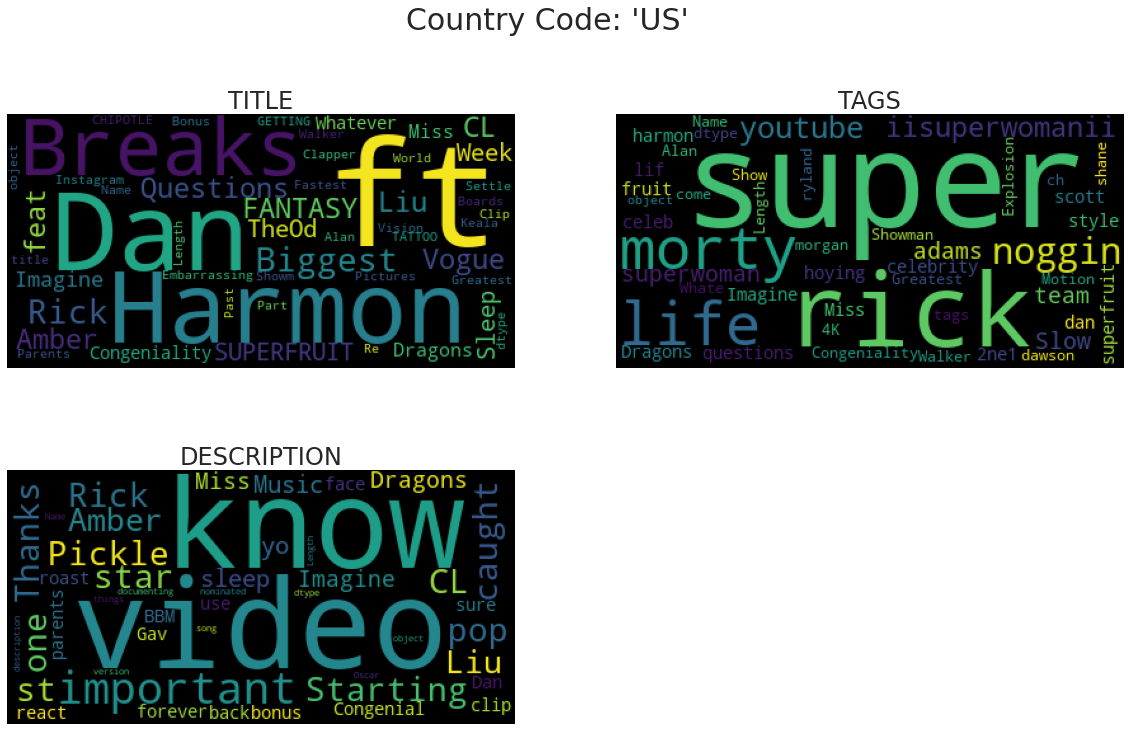

In [159]:
plot_countrywise("US")

**GREAT BRITAIN YOUTUBE VIDEOS TOP WORDS**

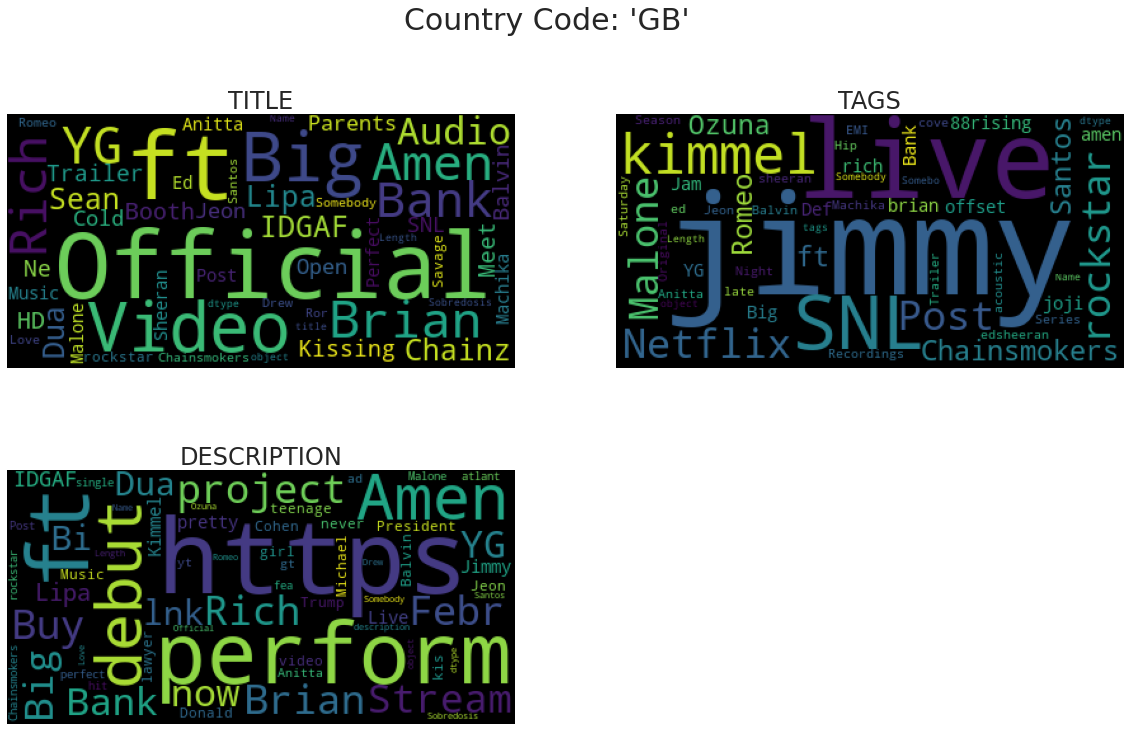

In [160]:
plot_countrywise("GB")

**Exercise**

Analyze **Indian** and **Canadian** Videos

**Do descriptive videos get more number of likes ?**

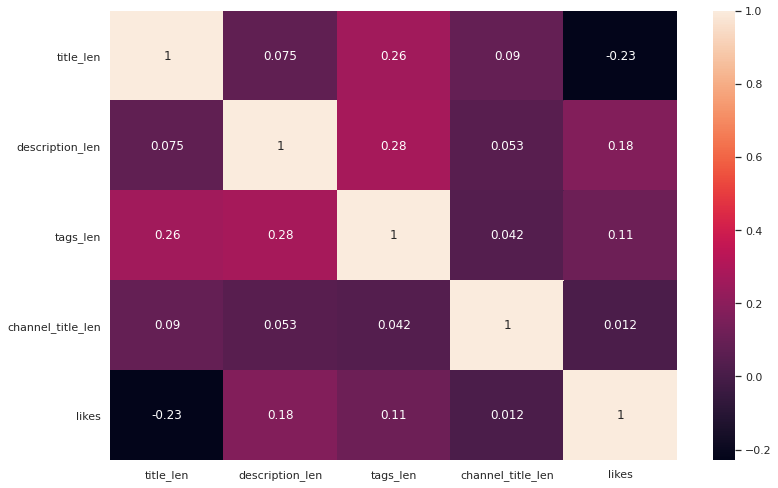

In [161]:
train['title_len'] = train['title'].apply(lambda x: len(x))
train['description_len'] = train['description'].apply(lambda x: len(x))
train['tags_len'] = train['tags'].apply(lambda x: len(x))
train['channel_title_len'] = train['channel_title'].apply(lambda x: len(x))

_  = sns.heatmap(train[['title_len', 'description_len', 'tags_len', 'channel_title_len', 'likes']].corr(), annot = True)

So if you keep your title length short and description long, you are having higher chances of getting likes.

# **Baseline Model(s)**

## **METRIC**

**RMSE(Root Mean Square Error)**

Simply put RMSE is the Root Mean Squared Error of the actual and predicted values.


The Robustness of RMSE to the outliers, the property of calculating the relative error between the Predicted and Actual Values, the most unique property of the RMSE that it penalizes the underestimation of the actual value more severely than it does for the Overestimation.



In [162]:
train[num_cols + ['likes']] = train[num_cols + ['likes']].apply(lambda x: np.log1p(x))
test[num_cols+ ['likes']] = test[num_cols + ['likes']].apply(lambda x: np.log1p(x))

## **Model A. (Predicting all instances as mean)**

In [116]:
train_proc = train.copy()
test_proc = test.copy()

In [163]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

target = train_proc[TARGET_COL]

In [164]:
preds_target = pd.Series([target.mean()] * len(train_proc))

RMSE = rmse(target, preds_target)

print(f'RMSE is: {RMSE}')

RMSE is: 62721.098580348145


In [165]:
print(preds_target, target)

0        12865.451842
1        12865.451842
2        12865.451842
3        12865.451842
4        12865.451842
             ...     
20843    12865.451842
20844    12865.451842
20845    12865.451842
20846    12865.451842
20847    12865.451842
Length: 20848, dtype: float64 792       4189.0
11404       94.0
23783        7.0
11483     3024.0
21553     6635.0
          ...   
10955    10490.0
17289    17351.0
5192        85.0
12172    16689.0
235        837.0
Name: likes, Length: 20848, dtype: float64


## **Model B. (Predicting all instances as median)**

In [166]:
preds_target = pd.Series([target.median()] * len(train_proc))

RMSE = rmse(target, preds_target)

print(f'RMSE score is: {RMSE}')

RMSE score is: 63564.761440221904


## **Model C. (Predicting using number of views)**

In [167]:
likes_per_view = ((train_proc['likes'] + 1)/(train_proc['views'] + 1))
likes_per_view.mean()

0.02984453007847239

In [168]:
preds_target = train_proc['views'] * 0.0298

RMSE = rmse(target, preds_target)

print(f'RMSE score is: {RMSE}')

RMSE score is: 45598.72492477735


## **Model D. (Predicting using number of comments)**



In [169]:
likes_per_comment = (train_proc['likes'] + 1)/(train_proc['comment_count'] + 1)
likes_per_comment.mean()

37.824784249025704

In [170]:
preds_target = train['comment_count'] * 37.824

RMSE = rmse(target, preds_target)

print(f'RMSE score is: {RMSE}')

RMSE score is: 64009.83365767657


## **Model E. (Predicting using Dislikes)**



In [171]:
likes_per_dislike = (train_proc['likes'] + 1)/(train_proc['dislikes']+1)
likes_per_dislike.mean()

34.81158382911906

In [172]:
preds_target = train_proc['dislikes'] * 34.811

RMSE = rmse(target, preds_target)

print(f'RMSE score is: {RMSE}')

RMSE score is: 97165.82921909734
